# MNIST: learning to recognize handwritten digits

## Dataset exploration

Before starting a machine learning or data science task, it is always useful to familiarize yourself with the data set and its context.

### Required imports

In [1]:
from collections import Counter
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Using TensorFlow backend.


### Obtaining the dataset

In Keras' datasets module we have a handle to the MNIST dataset we want to use in this notebook.  Download the training and test set for this data.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Dimensions and types

Determine the shape and type of the training and the test set.

In [3]:
x_train.shape, x_train.dtype, y_train.shape, y_train.dtype

((60000, 28, 28), dtype('uint8'), (60000,), dtype('uint8'))

In [4]:
x_test.shape, x_test.dtype, y_test.shape, y_test.dtype

((10000, 28, 28), dtype('uint8'), (10000,), dtype('uint8'))

The training set has 60,000 examples, the test set 10,000.  The input is a 28 $\times$ 28 matrix of unsigned 8-bit integers, the output a single unsigned 8-bit integer.

### Data semantics

 Each input represents a scanned grayscale image of a handwritten digit, the output is the corresponding integer.

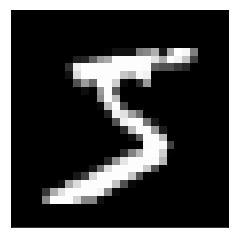

In [5]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0], cmap='gray');

In [6]:
y_train[0]

5

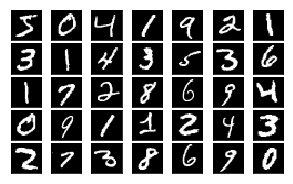

In [7]:
rows = 5
cols = 7
figure, axes = plt.subplots(rows, cols, figsize=(5, 3))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for img_nr in range(rows*cols):
    row = img_nr//cols
    col = img_nr % cols
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].imshow(x_train[img_nr], cmap='gray')

In [8]:
y_train[:rows*cols].reshape(rows, cols)

array([[5, 0, 4, 1, 9, 2, 1],
       [3, 1, 4, 3, 5, 3, 6],
       [1, 7, 2, 8, 6, 9, 4],
       [0, 9, 1, 1, 2, 4, 3],
       [2, 7, 3, 8, 6, 9, 0]], dtype=uint8)

So this proves that I'm certainly not the only one cursed with bad handwriting.

### Data distribution

An important question is whether all digits are represented in the training and test set, and what the distribution is.  This may have an impact on the accuracy of the trained model.

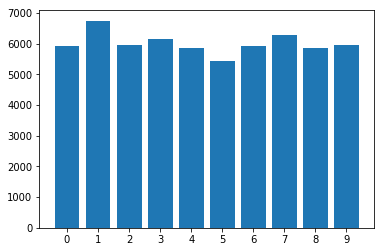

In [9]:
distr = Counter(y_train)
figure, axes = plt.subplots()
axes.set_xticks(list(distr.keys()))
axes.bar(list(distr.keys()), list(distr.values()));

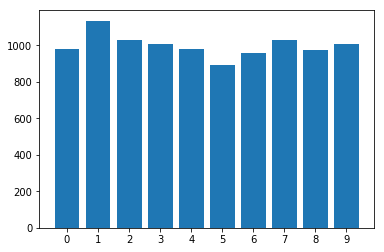

In [10]:
distr = Counter(y_test)
figure, axes = plt.subplots()
axes.set_xticks(list(distr.keys()))
axes.bar(list(distr.keys()), list(distr.values()));

Although some digits like 1 are overrepresented, and others, e.g., 5 are underrepresented, the distribution seems to be reasonably uniform, and it is likely no special care needs to be taken.

## Data preparation

Before we can start doing machine learning on the data, some preparations are required.  In this case, the data set is clean, which simplifies this step considerably.  Although it would be better to create a pipeline using the scikit-learn framework, we'll do the preparation by hand in this case.

### Required imports

In [21]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

### Transforming the data

Rather than using the 28 $\times$ 28 images as input, we reshape each image to a 784 array.

In [13]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

Most learning algorithms work better when the input data is normalized to the interval $[0, 1]$.

In [15]:
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

The output can be transformed to categorical data, i.e., one category for each digit, rather than a `uint8`. This is a one-hot encoding, so the output is now an array consisting of a single 1.0 value, and nine 0.0 values.  Note that the type of the output is now also `float32`.

In [17]:
y_train = np_utils.to_categorical(y_train)
x_test = np_utils.to_categorical(y_test)

In [20]:
y_train.shape

(60000, 10)

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

### Validation set

In order to make this reproducible, we have to seed the random number generator.

In [25]:
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [27]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((33750, 784), (11250, 784), (33750, 10), (11250, 10))

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

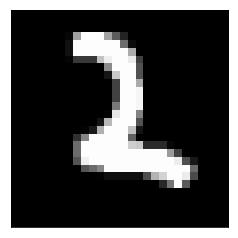

In [29]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray');

In [30]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Everything seems fine, input/output are as expected, and we can start doing some machine learning.

## Classic multilayer neural network

We start off training a classic multilayer neural network to familiarie ourselves with the keras framework.

### Required imports

In [31]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

### Model definition

We will create a fully connected neural network with 784 input units (28 $\times$ 28 pixels), two hidden layers with 512 units each, and an output layter with 10 units (ten categories, one per digit). For the two hidden layers, we will use a ReLU activation function, and a SoftMax for the output layer.

In [40]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Now we can can compile the model, specifying the loss function (categorical cross-entropy), the optimizer (SGD, Stochastic Gradient Descent), and the metrics (accuracy) we want to use.

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])

### Training

In [43]:
model_history = model.fit(x_train, y_train, batch_size=128, epochs=100,
                          verbose=1, validation_data=(x_val, y_val))

Train on 33750 samples, validate on 11250 samples
Epoch 1/100
33750/33750 [==============================] - 19s 554us/step - loss: 2.2307 - acc: 0.1804 - val_loss: 2.1331 - val_acc: 0.3393
Epoch 2/100
33750/33750 [==============================] - 17s 510us/step - loss: 2.0427 - acc: 0.4715 - val_loss: 1.9533 - val_acc: 0.5668
Epoch 3/100
33750/33750 [==============================] - 18s 527us/step - loss: 1.8645 - acc: 0.6145 - val_loss: 1.7742 - val_acc: 0.6511
Epoch 4/100
33750/33750 [==============================] - 18s 538us/step - loss: 1.6852 - acc: 0.6795 - val_loss: 1.5945 - val_acc: 0.6993
Epoch 5/100
33750/33750 [==============================] - 19s 570us/step - loss: 1.5090 - acc: 0.7192 - val_loss: 1.4222 - val_acc: 0.7356
Epoch 6/100
33750/33750 [==============================] - 20s 597us/step - loss: 1.3444 - acc: 0.7515 - val_loss: 1.2658 - val_acc: 0.7647
Epoch 7/100
33750/33750 [==============================] - 21s 631us/step - loss: 1.1985 - acc: 0.7748 - val_l

Epoch 59/100
33750/33750 [==============================] - 11s 331us/step - loss: 0.3215 - acc: 0.9096 - val_loss: 0.3288 - val_acc: 0.9080
Epoch 60/100
33750/33750 [==============================] - 11s 326us/step - loss: 0.3195 - acc: 0.9099 - val_loss: 0.3271 - val_acc: 0.9087
Epoch 61/100
33750/33750 [==============================] - 11s 321us/step - loss: 0.3176 - acc: 0.9107 - val_loss: 0.3252 - val_acc: 0.9090
Epoch 62/100
33750/33750 [==============================] - 11s 330us/step - loss: 0.3157 - acc: 0.9110 - val_loss: 0.3235 - val_acc: 0.9092
Epoch 63/100
33750/33750 [==============================] - 11s 331us/step - loss: 0.3139 - acc: 0.9114 - val_loss: 0.3220 - val_acc: 0.9100
Epoch 64/100
33750/33750 [==============================] - 11s 320us/step - loss: 0.3121 - acc: 0.9126 - val_loss: 0.3201 - val_acc: 0.9100
Epoch 65/100
33750/33750 [==============================] - 11s 330us/step - loss: 0.3103 - acc: 0.9125 - val_loss: 0.3186 - val_acc: 0.9103
Epoch 66/100


Plot the history of the training process.

In [44]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')

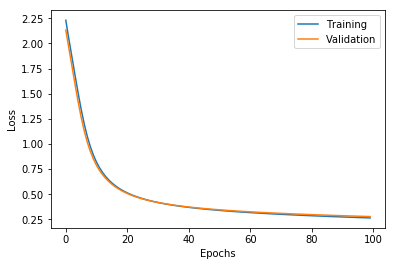

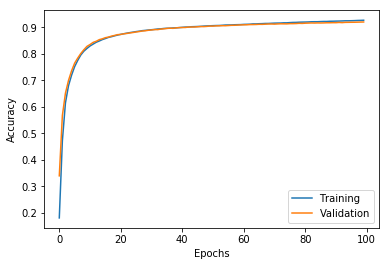

In [45]:
plot_history(model_history)